# **Capital Deepening Dredging**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pd.options.display.float_format = '{:,}'.format# show , for thousands
pd.set_option('display.max_columns', 1000)# show all columns

from pathlib import Path

# change the width of the cells on screen 
from IPython.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

In [2]:
Dredge_power = 700 #kW
Production_rate_clay = 1800 + 200/(1000-500)*(3000-1800) #m3/h
Production_rate_sand = 1800 + 200/(1000-500)*(3000-1800)
Production_rate_cemented = 400 + 200/(1000-500)*(700-400)

for soil_type, production_rate in zip(['clay', 'sand', 'cemented sand'], 
                                      [Production_rate_clay, Production_rate_sand, Production_rate_cemented]):
    print(f'Production rate of {soil_type}: {production_rate:.1f} m3/h')
    print(f'Maximum weekly production rate of {soil_type}: {production_rate*24*7:.1f} m3/week\n')

Production rate of clay: 2280.0 m3/h
Maximum weekly production rate of clay: 383040.0 m3/week

Production rate of sand: 2280.0 m3/h
Maximum weekly production rate of sand: 383040.0 m3/week

Production rate of cemented sand: 520.0 m3/h
Maximum weekly production rate of cemented sand: 87360.0 m3/week



**Transporting clay and cemented material using pipeline**

In [4]:
rho_sand = 2000
rho_water = 1025
rho_cemented = 2400
rho_clay = 1800
rho_mixture = 1500
rho_mixture_cemented = 1250

#Sand
n_sand = 0.5
k0_sand= 2.5 * 10**-5
k1_sand = 5 * 10**-5
friction_angle_sand= 30

#Cemented
n_cemented = 0.32
k0_cemented = 2*10**-6
k1_cemented = 5*10**-6
friction_angle_cemented = 30

#clay
n_clay = 0.55
k0_clay = 1*10**-9
k1_clay = 1 * 10**-6
friction_angle_clay = 15

def calc_vm(Qg,rho_s, rho_w, rho_m, n0, D, ft = 1):
    return Qg*(rho_s-rho_w)*(1-n0) / ((rho_m-rho_w)*np.pi/4*D**2) /ft
print('Velocity clay (0.8 m diameter):', round(calc_vm(Qg = 1,rho_s = rho_clay, rho_w = rho_water, rho_m = rho_mixture, n0 = n_clay, D=0.8),2), 'm/s')
print('Velocity sand (0.8 m diameter):', round(calc_vm(Qg = 1,rho_s = rho_sand, rho_w = rho_water, rho_m = rho_mixture, n0 = n_sand, D=0.8),2), 'm/s')
print('Velocity cemented sand (0.8 m diameter):', round(calc_vm(Qg = 1,rho_s = rho_cemented, rho_w = rho_water, rho_m = rho_mixture_cemented, n0 = n_cemented, D=0.8),2), 'm/s')

Velocity clay (0.8 m diameter): 1.46 m/s
Velocity sand (0.8 m diameter): 2.04 m/s
Velocity cemented sand (0.8 m diameter): 8.27 m/s


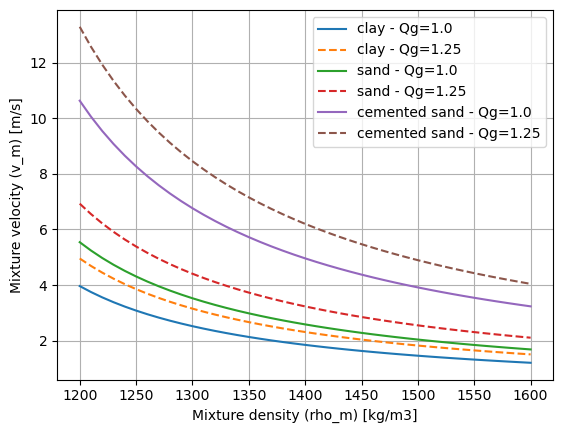

In [5]:
# compute vm series per soil type
D = 0.8
rho_s_list = [rho_clay, rho_sand, rho_cemented]
n0_list = [n_clay, n_sand, n_cemented]
soil_names = ['clay', 'sand', 'cemented sand']

rho_serie = np.arange(1200,1600+10,10)
vm_avg_series = []
vm_peak_series = []

for rho_s_val, n0_val, rho_m in zip(rho_s_list, n0_list, rho_serie):
    vm_avg_series.append([calc_vm(Qg=1.0, rho_s=rho_s_val, rho_w=rho_water, rho_m=rho_m, n0=n0_val, D=D)
                          for rho_m in rho_serie])
    vm_peak_series.append([calc_vm(Qg=1.25, rho_s=rho_s_val, rho_w=rho_water, rho_m=rho_m, n0=n0_val, D=D)
                           for rho_m in rho_serie])

for name, vm_avg_s, vm_peak_s in zip(soil_names, vm_avg_series, vm_peak_series):
    plt.plot(rho_serie, vm_avg_s, label=f'{name} - Qg=1.0')
    plt.plot(rho_serie, vm_peak_s, '--', label=f'{name} - Qg=1.25')

plt.xlabel('Mixture density (rho_m) [kg/m3]')
plt.ylabel('Mixture velocity (v_m) [m/s]')
plt.legend()
plt.grid(True)
plt.show()

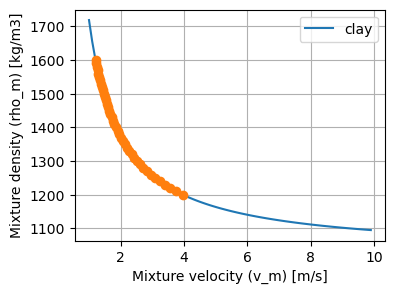

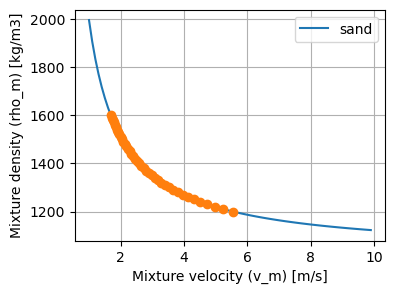

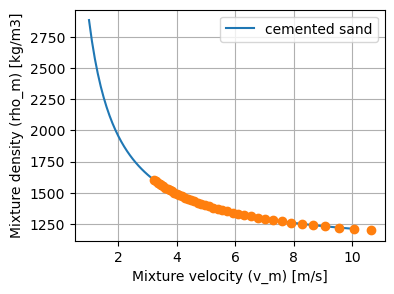

Formula is correct; plotted rho_m vs vm for each soil.


In [93]:
Pipe_D = 0.8
A = 0.25*np.pi*D**2

def calc_rho_m(Q,A,n,ft,rho_s,rho_w,vm):
    C1 = Q/A * (1-n) / ft
    return (C1*rho_s - C1*rho_w + rho_w*vm)/vm

vm_serie = np.arange(3,10,0.1)
rho_m_per_soil = (rho_mixture, rho_mixture, rho_mixture_cemented)
# plot results
for name, rho_series in zip(soil_names, rho_m_per_soil):
    D = Pipe_D
    A = 0.25*np.pi*D**2

    vm_serie = np.arange(1,10,0.1)

    # compute rho_m over the vm range for each soil (use corresponding n0)
    rho_m_per_soil = []
    for rho_s, n0 in zip(rho_s_list, n0_list):
        rho_m_per_soil.append([
            calc_rho_m(Q=1.0, A=A, n=n0, ft=1, rho_s=rho_s, rho_w=rho_water, vm=vm)
            for vm in vm_serie])

for i, (name, rho_series) in enumerate(zip(soil_names, rho_m_per_soil)):
    plt.figure(figsize=(4,3))
    plt.plot(vm_serie, rho_series, label=name)
    plt.plot(vm_avg_series[i], rho_serie, 'o')  # mark the previous points for Qg=1
    plt.xlabel('Mixture velocity (v_m) [m/s]')
    plt.ylabel('Mixture density (rho_m) [kg/m3]')
    plt.legend()
    plt.grid(True)
    plt.show()
print('Formula is correct; plotted rho_m vs vm for each soil.')

In [94]:
L = 1000 #m from basin to LR area
resistance_coefficient = 0.012
Pipe_D = 0.8

def calc_Delta_P(lambda_, rho_m,rho_w,L,D,v):
    g=9.81
    return 1/2*lambda_ * rho_m /rho_w *L/D*(v**2)/g*rho_m*g

v = 1/(0.25*np.pi*Pipe_D**2) # Q (1 m3/s) / A [m2]

def calc_Delta_P2(rho_m,He):
    return rho_m*9.81*He

rho_m = [rho_mixture, rho_mixture, rho_mixture_cemented]
for soil_name, rho, n, He in zip(soil_names, (rho_m), (n0_list), (15,18,19.5)):    
    DeltaP1 = calc_Delta_P(lambda_ = 0.012, rho_m = rho, rho_w=rho_water, L = 1000,D = Pipe_D,v = v)
    DeltaP2 = calc_Delta_P2(rho, He)
    DeltaP3 = (0.15*2 + 1.0 + 0.45) * 0.5 * rho * v**2  #for 2 bends, 1 exit, 1 entrance
    Total_Delta_P = DeltaP1 + DeltaP2 + DeltaP3

    print(soil_name)
    print(f'  - Delta P 1: {DeltaP1/1000:.2f} kN/m2')
    print(f'  - Delta P 2: {DeltaP2/1000:.2f} kN/m2')
    print(f'  - Delta P 3: {DeltaP3/1000:.2f} kN/m2')
    print(f'  - Total Delta P: {Total_Delta_P/1000:.2f} kN/m2\n')



clay
  - Delta P 1: 65.16 kN/m2
  - Delta P 2: 220.72 kN/m2
  - Delta P 3: 5.19 kN/m2
  - Total Delta P: 291.08 kN/m2

sand
  - Delta P 1: 65.16 kN/m2
  - Delta P 2: 264.87 kN/m2
  - Delta P 3: 5.19 kN/m2
  - Total Delta P: 335.22 kN/m2

cemented sand
  - Delta P 1: 45.25 kN/m2
  - Delta P 2: 239.12 kN/m2
  - Delta P 3: 4.33 kN/m2
  - Total Delta P: 288.70 kN/m2



In [110]:
# D = 0.8
# A = 0.25 * np.pi * D**2

# def calc_cv(rho_m, rho_w, rho_s):
#     return (rho_m - rho_w) / (rho_s - rho_w)

# def calc_Es(n0, delta_P, cv):
#     return (1 - n0) * delta_P / cv

# pump_eff = 0.8   # pump efficiency (fraction)
# Q_flow = 1 # [1440/3600, 1440,/3600, 520/3600]    # m3/s used in calc_rho_m and power calc 


# Delta_P_series_all = []
# Ph_series_all = []

# for rho_s, n0, He, soil in zip(rho_s_list, n0_list, (15, 18, 19.5), soil_names):
#     Delta_P_serie = []
#     Ph_serie = []
#     for vm in vm_serie:
#         # compute mixture density for given vm and soil parameters
#         rho_m = calc_rho_m(Q=Q_flow, A=A, n=n0, ft=1, rho_s=rho_s, rho_w=rho_water, vm=vm)

#         # pressure losses: P1 (friction) and P2 (static/elevation) and P3 (minor losses)
#         P1 = calc_Delta_P(lambda_=resistance_coefficient, rho_m=rho_m, rho_w=rho_water, L=L, D=D, v=vm)
#         P2 = calc_Delta_P2(rho_m, He)
#         P3 = (0.15*2 + 1.0 + 0.45) * 0.5 * rho_m * vm**2  #for 2 bends, 1 exit, 1 entrance
#         Delta_P = P1 + P2 + P3

#         # store as kPa for plotting
#         Delta_P_serie.append(Delta_P / 1000.0)

#         # pump power required [kW] for Q_flow (m3/s): Power (kW) = Delta_P(Pa)*Q(m3/s)/1000, account for efficiency
#         Ph = (Delta_P * Q_flow) / 1000.0 / pump_eff
#         Ph_serie.append(Ph)
#     plt.plot(vm_serie, Delta_P_serie, label=soil)
#     Delta_P_series_all.append(Delta_P_serie)
#     Ph_series_all.append(Ph_serie)
# plt.xlabel('Mixture velocity (vm) [m/s]')
# plt.ylabel('Total pressure head [kPa]')
# plt.title ('Total pressure loss')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plot pump power required
# for soil, Ph_serie in zip(soil_names, Ph_series_all):
#     plt.plot(vm_serie, Ph_serie, label=soil)
# plt.xlabel('Mixture velocity (vm) [m/s]')
# plt.ylabel('Pump power [kW]')
# plt.title('Required power')
# plt.legend()
# plt.grid(True)
# plt.show()
# # print(vm_serie)

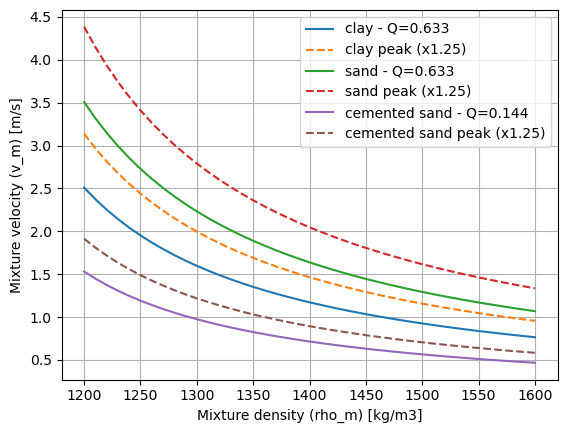

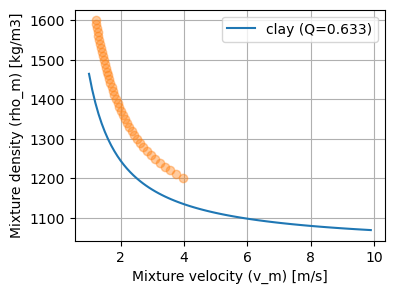

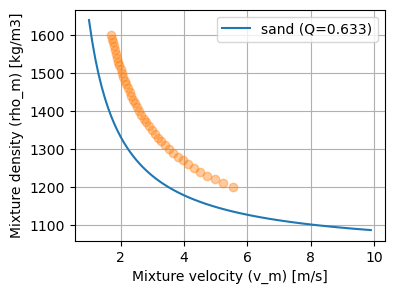

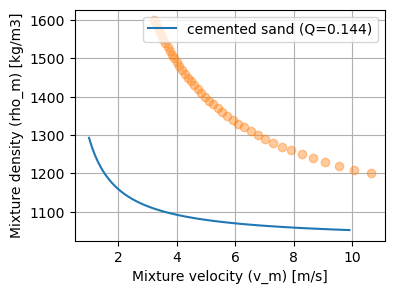

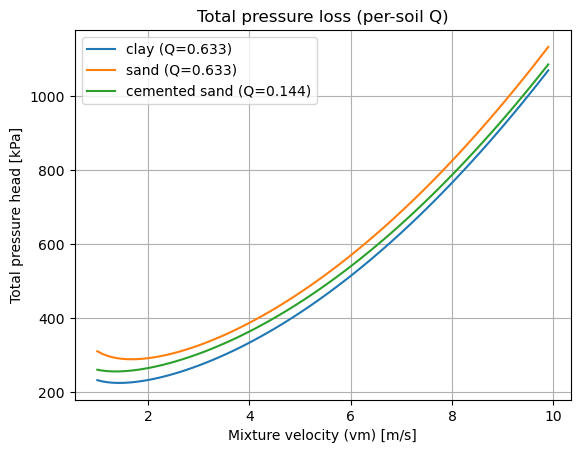

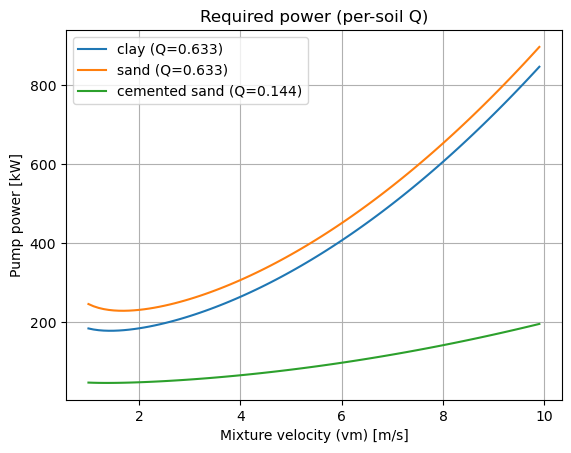

In [109]:
# Update Q from a single value to per-soil values and recompute plots/results
# Q order follows soil_names = ['clay','sand','cemented sand']
Q_values = [0.633, 0.633, 0.144]  # m3/s for clay, sand, cemented sand

D = 0.8
A = 0.25 * np.pi * D**2

# 1) Recompute vm vs rho_m for each soil using per-soil Q
vm_avg_series_Q = []
vm_peak_series_Q = []
for Qg, rho_s, n0 in zip(Q_values, rho_s_list, n0_list):
    avg = [calc_vm(Qg=Qg, rho_s=rho_s, rho_w=rho_water, rho_m=rho_m_val, n0=n0, D=D)
           for rho_m_val in rho_serie]
    peak = [calc_vm(Qg=Qg*1.25, rho_s=rho_s, rho_w=rho_water, rho_m=rho_m_val, n0=n0, D=D)
            for rho_m_val in rho_serie]
    vm_avg_series_Q.append(avg)
    vm_peak_series_Q.append(peak)

plt.figure()
for name, avg, peak in zip(soil_names, vm_avg_series_Q, vm_peak_series_Q):
    plt.plot(rho_serie, avg, label=f'{name} - Q={Q_values[soil_names.index(name)]:.3f}')
    plt.plot(rho_serie, peak, '--', label=f'{name} peak (x1.25)')
plt.xlabel('Mixture density (rho_m) [kg/m3]')
plt.ylabel('Mixture velocity (v_m) [m/s]')
plt.legend()
plt.grid(True)
plt.show()

# 2) Recompute rho_m vs vm using per-soil Q (for vm range)
vm_range = vm_serie  # reuse vm_serie defined earlier
rho_m_per_soil_Q = []
for Q, rho_s, n0 in zip(Q_values, rho_s_list, n0_list):
    rho_series = [calc_rho_m(Q=Q, A=A, n=n0, ft=1, rho_s=rho_s, rho_w=rho_water, vm=vm)
                  for vm in vm_range]
    rho_m_per_soil_Q.append(rho_series)

for i, (name, rho_series) in enumerate(zip(soil_names, rho_m_per_soil_Q)):
    plt.figure(figsize=(4,3))
    plt.plot(vm_range, rho_series, label=f'{name} (Q={Q_values[i]:.3f})')
    # mark previous points for Qg=1 if available (vm_avg_series exists)
    if i < len(vm_avg_series):
        plt.plot(vm_avg_series[i], rho_serie, 'o', alpha=0.4)
    plt.xlabel('Mixture velocity (v_m) [m/s]')
    plt.ylabel('Mixture density (rho_m) [kg/m3]')
    plt.legend()
    plt.grid(True)
    plt.show()

# 3) Recompute total pressure loss and pump power using per-soil Q (based on cell 8 logic)
Delta_P_series_all_Q = []
Ph_series_all_Q = []
pump_eff = pump_eff if 'pump_eff' in globals() else 0.8

for Q_flow, rho_s, n0, He, soil in zip(Q_values, rho_s_list, n0_list, (15, 18, 19.5), soil_names):
    Delta_P_serie = []
    Ph_serie = []
    for vm in vm_range:
        rho_m = calc_rho_m(Q=Q_flow, A=A, n=n0, ft=1, rho_s=rho_s, rho_w=rho_water, vm=vm)
        P1 = calc_Delta_P(lambda_=resistance_coefficient, rho_m=rho_m, rho_w=rho_water, L=L, D=D, v=vm)
        P2 = calc_Delta_P2(rho_m, He)
        P3 = (0.15*2 + 1.0 + 0.45) * 0.5 * rho_m * vm**2
        Delta_P = P1 + P2 + P3
        Delta_P_serie.append(Delta_P / 1000.0)  # kPa
        Ph = (Delta_P * Q_flow) / 1000.0 / pump_eff  # kW
        Ph_serie.append(Ph)
    Delta_P_series_all_Q.append(Delta_P_serie)
    Ph_series_all_Q.append(Ph_serie)
    plt.plot(vm_range, Delta_P_serie, label=f'{soil} (Q={Q_flow:.3f})')

plt.xlabel('Mixture velocity (vm) [m/s]')
plt.ylabel('Total pressure head [kPa]')
plt.title('Total pressure loss (per-soil Q)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
for soil, Ph_serie, Q_flow in zip(soil_names, Ph_series_all_Q, Q_values):
    plt.plot(vm_range, Ph_serie, label=f'{soil} (Q={Q_flow:.3f})')
plt.xlabel('Mixture velocity (vm) [m/s]')
plt.ylabel('Pump power [kW]')
plt.title('Required power (per-soil Q)')
plt.legend()
plt.grid(True)
plt.show()

In [96]:
def V_trench(B,H,phi,L):#phi in degrees, B = bottom width, H = layer thickness
    phi_rad = phi*np.pi/180
    A = H*(B+H/np.tan(phi_rad))*L
    B1 = B + 2*H/np.tan(phi_rad)
    return A,B1

V_sand, B_top_sand = V_trench(B = 200,H = 3,phi = 30, L=750) 
V_clay, B_top_clay = V_trench(B = 200,H = 2,phi = 15, L=750)
V_cemented, B_top_cemented = V_trench(B = 200,H = 1.5,phi = 30, L=750)
print('Volume of sand:', round(V_sand,0) ,'m3, top width:', round(B_top_sand,0), 'm')
print('Volume of clay:', round(V_clay,0) ,'m3, top width:', round(B_top_clay,0), 'm')
print('Volume of cemented sand:', round(V_cemented,0) ,'m3, top width:', round(B_top_cemented,0), 'm \n')

Volume of sand: 461691.0 m3, top width: 210.0 m
Volume of clay: 311196.0 m3, top width: 215.0 m
Volume of cemented sand: 227923.0 m3, top width: 205.0 m 



# **Calculation of cavitation**

Dillation (Delta n): 0.1471
Average permeability(k mean): 3.5e-06
The force P2 non cavitation: 37922.66 kN/m
The force P2 non cavitation: 37.92 MN/m

The average elevation (z mean): 9.0 m
The force P2: 76.42 kN/m
The force P2: 0.08 N/m 1e6
the lowest value will take place, so this situation will be cavitating


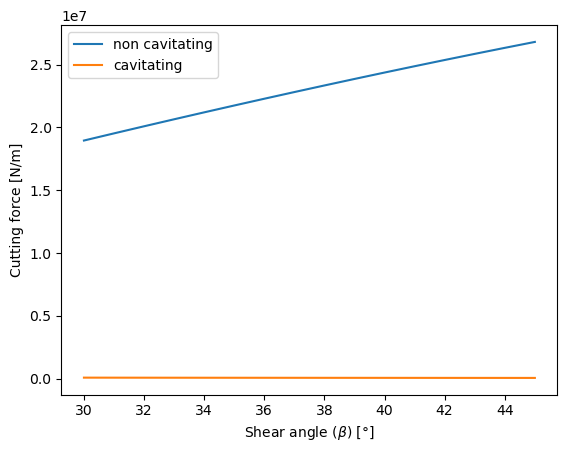

In [97]:
#CLAY
n0_cemented = 0.22
n1_cemented = 0.32
k0_cemented = 2 * 10**-6
k1_cemented = 5 * 10**-6
phi_cemented  = 30

v = 5 #m/s
h = 0.2 #m
alpha = 45 #deg
delta = 20 #deg

def calc_dn(n0_cemented,n1_cemented):
    return (n1_cemented-n0_cemented)/(1-n1_cemented)

print('Dillation (Delta n):', round(calc_dn(n0_cemented,n1_cemented),4))

def calc_k_mean(k0_cemented,k1_cemented):
    return (k0_cemented+k1_cemented)/2

k_mean = calc_k_mean(k0_cemented,k1_cemented)
print('Average permeability(k mean):', round(k_mean, 10))

def calc_p2_NO_cavitation(rho_w,b,h,v,k,delta_n):
    return 0.33*rho_w*9.81*b*h**2*(v/k)*delta_n

P2_NO_cavit = calc_p2_NO_cavitation(rho_w=1025,b=1,h=0.2,v=5,k=k_mean,delta_n = 0.2)
print('The force P2 non cavitation:', round(P2_NO_cavit/1e3, 2) , 'kN/m')
print('The force P2 non cavitation:', round(P2_NO_cavit/1e6, 2) , 'MN/m\n')

z1 = 8
z2 = 10
def calc_z_mean(z1,z2):
    return(z1+z2)/2

z_mean = calc_z_mean(z1,z2)
print('The average elevation (z mean):', z_mean , 'm')

def calc_P2_cavitation(rho_w,b,h,z,beta):
    beta_rad = beta*np.pi/180
    return rho_w*9.81*b*h*(z+10)/np.sin(beta_rad)

P2_cavit = calc_P2_cavitation(rho_w =1025,b=1,h=0.2,z=z_mean,beta=30)

print('The force P2:',round(P2_cavit/1e3, 2) , 'kN/m')
print('The force P2:',round(P2_cavit/1e6, 2) , 'N/m 1e6')

P2_NO_cavit_serie = []
P2_cavit_serie = []

angle_serie = np.arange(30,45+1,1)

for beta in angle_serie:
    P2_NO_cavit_serie.append(calc_p2_NO_cavitation(rho_w=1025,b=1,h=0.2,v=5,k=k_mean,delta_n = 0.2)*np.sin(beta*np.pi/180))# multiply by angle in addition to formula
    P2_cavit_serie.append(calc_P2_cavitation(rho_w =1025,b=1,h=0.2,z=z_mean,beta=beta))


plt.plot(angle_serie, P2_NO_cavit_serie, label = 'non cavitating')
plt.plot(angle_serie, P2_cavit_serie, label = 'cavitating')
plt.legend();
plt.xlabel(r'Shear angle ($\beta$) [$\degree$]')
plt.ylabel('Cutting force [N/m]')

print('the lowest value will take place, so this situation will be cavitating')

The optimal angle: 33.8 degrees


<>:20: SyntaxWarning: invalid escape sequence '\d'
<>:20: SyntaxWarning: invalid escape sequence '\d'
C:\Users\denis\AppData\Local\Temp\ipykernel_19580\3720289618.py:20: SyntaxWarning: invalid escape sequence '\d'
  plt.xlabel('shear angle (beta) [$\degree$]')


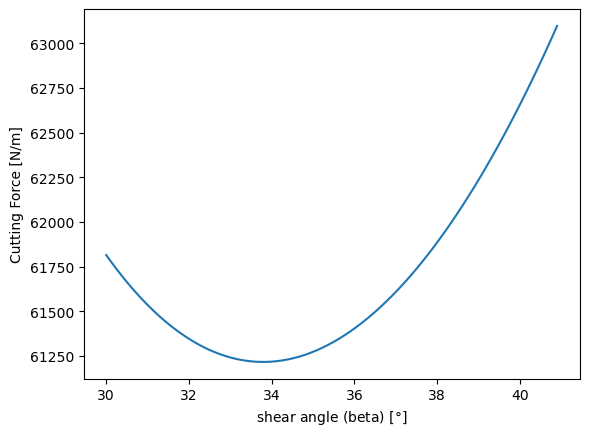

In [98]:
def calc_P1_cav(rho,b,h,alpha,z): # It follows the book, however the sugestion is that h should be h_blade, which influences the friction along the blade.
    return rho*9.81*b*h*(z+10)/np.sin(alpha*np.pi/180)

def calc_P2_cavitation(rho_w,b,h,z,beta): # used before, is correct
    beta_rad = beta*np.pi/180
    return rho_w*9.81*b*h*(z+10)/np.sin(beta_rad)

def calc_Fh(P1,P2,alpha,beta,delta,phi):
    return (P2*np.sin(phi*np.pi/180)*np.sin((alpha+delta)*np.pi/180)+P1*np.sin(delta*np.pi/180)*np.sin((beta+phi)*np.pi/180))/np.sin((alpha+beta+delta+phi)*np.pi/180)

beta_serie = np.arange(30,40+1,0.1)

Fh =[]
for beta in beta_serie:
    P1 = calc_P1_cav(rho = 1025,b=1,h=0.2,alpha=45, z = z_mean)
    P2 = calc_P2_cavitation(rho_w =1025,b=1,h=0.2,z=z_mean,beta=beta)
    Fh.append(calc_Fh(P1,P2,alpha=45,beta=beta,delta=delta,phi=phi_cemented))

plt.plot(beta_serie, Fh);
plt.xlabel('shear angle (beta) [$\degree$]')
plt.ylabel('Cutting Force [N/m]');

index_lowest = np.where(Fh == np.min(Fh))[0][0]
optimal_angle = beta_serie[index_lowest] 

print('The optimal angle:', round(optimal_angle,2), 'degrees')


Text(0, 0.5, 'Energy [kPa]')

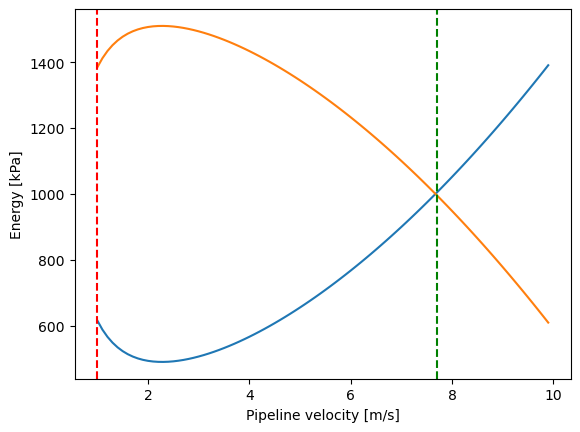

In [104]:

pump_energy = 2000 #kPa
# pump_added = pump_energy - Delta_P_serie  # vectorized
# all_pump_added.append(pump_added)

Delta_P_serie = np.array(Delta_P_serie)
pump_added = pump_energy - Delta_P_serie

plt.plot(vm_serie, Delta_P_serie, label='energy loss in pipeline')
plt.plot(vm_serie, pump_added, label='pump added energy')
plt.axvline(x=1.0, color='red', linestyle='--', label='deposition limit')
plt.axvline(x=7.7, color='green', linestyle='--', label='operating velocity')
plt.xlabel('Pipeline velocity [m/s]')
plt.ylabel('Energy [kPa]')

ValueError: x and y must have same first dimension, but have shapes (200,) and (70,)

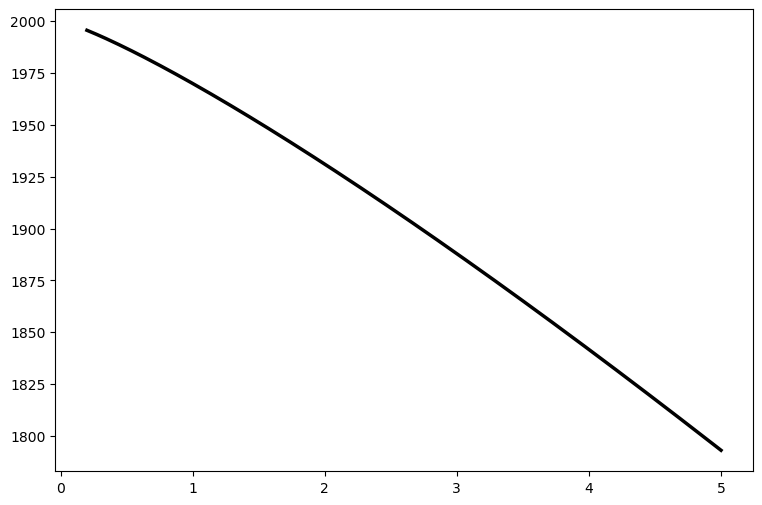

In [ ]:
# Pipeline velocity range [m/s]
v = np.linspace(0.2, 5, 200)


# Pipe energy
pipe_losses = Delta_P_serie
pump_added = 2000 - pipe_losses  # [kPa]


# Define deposit limit and operating velocity
v_deposit = 1.0   # [m/s]  #sand 1m/s, clay 0.3m/s, cemented sand 2m.x
v_operating = 2.5 # [m/s]  based on intersection of energy loss and pump energy added

# Plot
plt.figure(figsize=(9,6))

# Curves
plt.plot(v, pump_added, color='black', linewidth=2.5, label='Pump added energy')
plt.plot(v, pipe_losses, color='blue', linewidth=2.5, label='Pipe energy losses')

# Vertical lines
plt.axvline(v_deposit, color='red', linestyle='--', linewidth=2)
plt.axvline(v_operating, color='green', linestyle='--', linewidth=2)

# Labels near lines
plt.text(v_deposit + 0.05, 100, 'Deposit limit\nvelocity', color='red', fontsize=11)
plt.text(v_operating + 0.05, 200, 'Pipeline operating\nvelocity', color='green', fontsize=11)

# Intersection point (approximate)
idx = np.argmin(np.abs(pump_added - pipe_losses))
# plt.scatter(v[idx], pump_added[idx], color='black', zorder=5)
# plt.text(v[idx]+0.1, pump_added[idx]+10, "Operating point", fontsize=10)

# Formatting
plt.xlabel("Pipeline velocity [m/s]", fontsize=12)
plt.ylabel("Pressure [kPa]", fontsize=12)
plt.title("Pipeline Hydraulics for Sand–Water Mixture", fontsize=14)
plt.legend()
plt.grid(False)

# Aesthetic
plt.xlim(0, 5)
plt.ylim(0, 550)
plt.tight_layout()
plt.show()


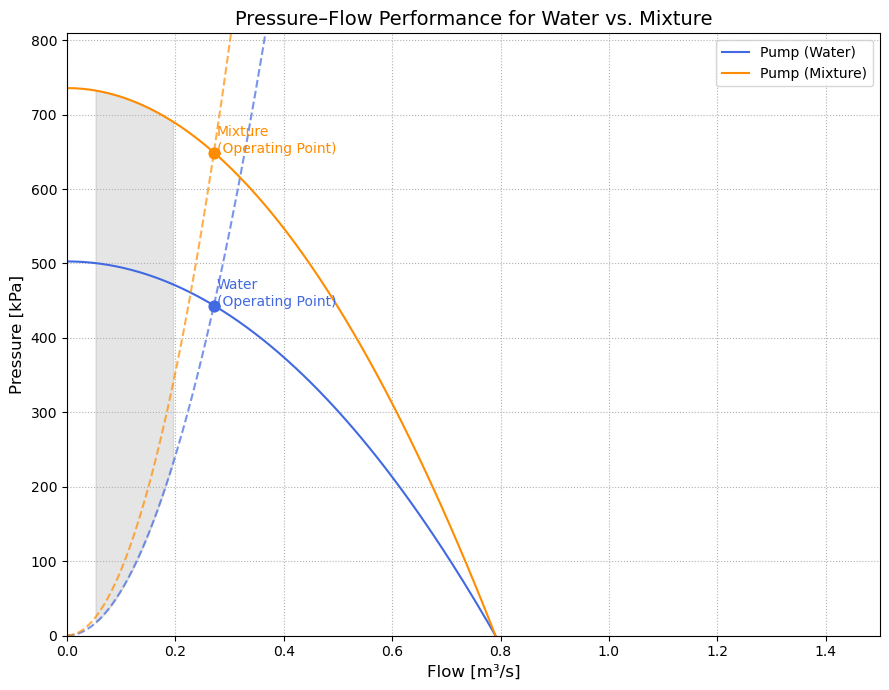

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# Constants
g = 9.81  # m/s²
rho_water = 1025  # kg/m³
rho_mix = 1500    # kg/m³

# Pump head curve: H = H0 - kQ² (in meters)
H0 = 50  # shutoff head [m]
k_pump = 80  # curve coefficient

# System curve: H = k_s * Q²
k_system = 600  # system coefficient

# Flow range [m³/s]
Q = np.linspace(0, 1.5, 200)

# Compute heads [m]
H_pump = H0 - k_pump * Q**2
H_system = k_system * Q**2

# Convert head to pressure [kPa]
P_pump_water = rho_water * g * H_pump / 1000
P_system_water = rho_water * g * H_system / 1000
P_pump_mix = rho_mix * g * H_pump / 1000
P_system_mix = rho_mix * g * H_system / 1000

# Find operating points (approximate intersection)
def find_intersection(x, y1, y2):
    idx = np.argmin(np.abs(y1 - y2))
    return x[idx], y1[idx]

Q_op_water, P_op_water = find_intersection(Q, P_pump_water, P_system_water)
Q_op_mix, P_op_mix = find_intersection(Q, P_pump_mix, P_system_mix)

# Plot setup
plt.figure(figsize=(9,7))

# Plot curves
plt.plot(Q, P_pump_water, label='Pump (Water)', color='royalblue')
plt.plot(Q, P_system_water, '--', color='royalblue', alpha=0.7)
plt.plot(Q, P_pump_mix, label='Pump (Mixture)', color='darkorange')
plt.plot(Q, P_system_mix, '--', color='darkorange', alpha=0.7)

# Shade the “operating region”
plt.fill_between(Q, P_system_water, P_pump_mix, where=(Q > 0.05) & (Q < 0.2),
                 color='gray', alpha=0.2)

# Mark intersection points
plt.scatter(Q_op_water, P_op_water, color='royalblue', s=60, zorder=5)
plt.scatter(Q_op_mix, P_op_mix, color='darkorange', s=60, zorder=5)
plt.text(Q_op_water+0.005, P_op_water, "Water\n(Operating Point)", color='royalblue')
plt.text(Q_op_mix+0.005, P_op_mix, "Mixture\n(Operating Point)", color='darkorange')

# Labels and formatting
plt.xlabel("Flow [m³/s]", fontsize=12)
plt.ylabel("Pressure [kPa]", fontsize=12)
plt.title("Pressure–Flow Performance for Water vs. Mixture", fontsize=14)

plt.grid(True, linestyle=':')
plt.legend()
plt.xlim(0, 1.5)
plt.ylim(0, np.max(P_pump_mix)*1.1)

plt.tight_layout()
plt.show()